In [30]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlp import MLP
import ast
import glob

In [63]:
def load_mlp_model(model_path):
    """Load the trained MLP model"""
    checkpoint = torch.load(model_path, map_location='cpu')
    if 'model' in checkpoint:
        model = checkpoint['model'].cuda()
    else:
        config = checkpoint['config']
        model = MLP(
            input_dim=config['input_dim'],
            hidden_dim=config['hidden_dims'][0],
            output_dim=config['output_dim']
        )#.cuda()
        #model.load_state_dict({k: v.cuda() for k, v in checkpoint['model_state_dict'].items()})
        model.load_state_dict({k: v for k, v in checkpoint['model_state_dict'].items()})
    model.eval()
    return model

def optimize_token_allocation(predictions, token_budget, W=16):
    """
    Optimize token allocation given predictions and budget constraint.
    predictions: list of prediction vectors from MLP
    token_budget: average token limit across all queries
    W: window size (16)
    Returns: list of token allocations for each query
    """
    num_queries = len(predictions)
    max_positions = len(predictions[0])
    
    # Convert predictions to numpy for easier manipulation
    pred_array = np.array(predictions)
    max_budget_per_query = max_positions * W
    
    # Initialize with minimum tokens
    allocations = np.ones(num_queries, dtype=int) * W
    
    # Calculate how many more tokens we can allocate
    remaining_budget = token_budget * num_queries - np.sum(allocations)
    
    while remaining_budget >= W:
        # For each query, calculate potential gain from adding W tokens
        best_gain = -1
        window_increase = 1
        while best_gain < 0:
            gains = []
            for i in range(num_queries):
                current_pos = allocations[i] // W - 1
                if current_pos + window_increase >= max_positions:
                    gains.append(-1)  # Can't allocate more tokens
                else:
                    gains.append(pred_array[i][current_pos + window_increase] - pred_array[i][current_pos])
            
            # Find query with maximum gain
            best_query = np.argmax(gains)
            best_gain = gains[best_query]
            if gains[best_query] <= 0:
                window_increase += 1
            if all([g == -1 for g in gains]):
                break
        #print(f"{remaining_budget} Best gain: {np.round(best_gain, 2)}")
        if best_gain == -1:
            print("No more gains, breaking")
            break
            
        # Allocate W more tokens to the best query
        allocations[best_query] += W
        remaining_budget -= W
    
    # Distribute remaining tokens
    i = 0
    while remaining_budget >= W:
        if all([a >= max_budget_per_query for a in allocations]):
            break
        if allocations[i % (num_queries)] + W <= max_budget_per_query:
            allocations[i % (num_queries)] += W
            remaining_budget -= W
        i += 1
        
    return allocations.tolist()

def load_gsm8k_data():
    """Load GSM8K data from CSV files"""
    # Load all Y data files
    all_data = []
    for split in ['train', 'test']:
        y_files = list(sorted(glob.glob(f"data/gsm8k_results/gsm8k_Y_{split}_*.csv")))
        x_files = list(sorted(glob.glob(f"data/gsm8k_results/gsm8k_X_{split}_*.csv")))
        print(split,len(x_files),len(y_files))
        
        for x_file, y_file in zip(x_files, y_files):
            df = pd.read_csv(y_file)
            df_x = pd.read_csv(x_file)[['question_id', 'hidden_state']]
            df = df.merge(df_x, on="question_id", how="left")
            df['early_stop_correct_proportions'] = df['early_stop_correct_proportions'].apply(ast.literal_eval)
            df['split'] = split
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)



In [64]:
# Load GSM8K data
print("Loading GSM8K data...")
df = load_gsm8k_data()
df["split"].value_counts()

Loading GSM8K data...
train 75 75
test 14 14


train    7450
test     1294
Name: split, dtype: int64

In [65]:
# Load the MLP model
model = load_mlp_model('models/mlp_gsm8k_train_layer_16_arch_256_act_relu_drop_0.00.pt')

    
# Get predictions from MLP
print("Getting predictions from MLP...")
with torch.no_grad():
        hidden_states = torch.tensor(np.vstack(df['hidden_state'].apply(ast.literal_eval).values), 
                                   dtype=torch.float32)#.cuda()
        predictions = model(hidden_states).cpu().numpy()
    
print("Optimizing token allocation...")
# Create DataFrame for results
budgets = range(16, 257, 16)  # Token budgets from 16 to 256 in steps of 16


C:\Users\Katrina\AppData\Local\Temp\ipykernel_75672\246931919.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


Input dim: 1536, Hidden dim: 256, Output dim: 16
Getting predictions from MLP...
Optimizing token allocation...


In [66]:
df["split"].value_counts()

train    7450
test     1294
Name: split, dtype: int64

In [67]:
from collections import Counter
results = []
for budget in budgets:
        print(f"Budget: {budget}")
        # Get optimized token allocations
        allocations = []
        allocations_oracle = []
        batch_size = 64
        for i in range(0, len(predictions), batch_size):
            batch_predictions = predictions[i:i+batch_size]
            batch_allocations = optimize_token_allocation(batch_predictions, budget)
            allocations.extend(batch_allocations)
            batch_actual = df['early_stop_correct_proportions'].values[i:i+batch_size]
            batch_allocations_oracle = optimize_token_allocation(batch_actual, budget)
            allocations_oracle.extend(batch_allocations_oracle)
        print(Counter(allocations))
        
        # Calculate accuracies
        for i, (pred, actual) in enumerate(zip(predictions, df['early_stop_correct_proportions'].values)):
            # Adaptive accuracy using MLP predictions
            window_idx = allocations[i] // 16 - 1
            adaptive_accuracy = actual[window_idx]
            
            # Nonadaptive accuracy (equal allocation)
            nonadaptive_window_idx = budget // 16 - 1
            nonadaptive_accuracy = actual[nonadaptive_window_idx]
            
            # Oracle accuracy
            oracle_window_idx = allocations_oracle[i] // 16 - 1
            oracle_accuracy = actual[oracle_window_idx]
            split = df['split'].iloc[i]
            
            results.append({
                'question_id': df['question_id'].iloc[i],  # Add question ID if available
                'budget': budget,
                'allocation': allocations[i],
                'accuracy_adaptive_model': adaptive_accuracy,
                'accuracy_nonadaptive': nonadaptive_accuracy,
                'accuracy_oracle': oracle_accuracy,
                'split': split
            })
            
        # Print summary statistics for this budget
        current_results = [r for r in results if r['budget'] == budget]
        print(f"Budget: {budget}")
        print(f"Adaptive Accuracy: {np.mean([r['accuracy_adaptive_model'] for r in current_results])}")
        print(f"Nonadaptive Accuracy: {np.mean([r['accuracy_nonadaptive'] for r in current_results])}")
        print(f"Oracle Accuracy: {np.mean([r['accuracy_oracle'] for r in current_results])}")

Budget: 16
Counter({16: 8744})
Budget: 16
Adaptive Accuracy: 0.12011207685269899
Nonadaptive Accuracy: 0.12011207685269899
Oracle Accuracy: 0.12011207685269899
Budget: 32
Counter({16: 7379, 144: 666, 48: 292, 176: 173, 32: 82, 160: 32, 64: 29, 96: 27, 80: 23, 112: 12, 256: 12, 128: 9, 240: 3, 208: 2, 224: 2, 192: 1})
Budget: 32
Adaptive Accuracy: 0.15863334858188471
Nonadaptive Accuracy: 0.11820105215004574
Oracle Accuracy: 0.20383348581884722
Budget: 48
Counter({16: 6354, 144: 838, 176: 641, 48: 426, 32: 187, 256: 160, 64: 30, 96: 26, 160: 24, 208: 13, 80: 13, 128: 10, 224: 9, 112: 9, 192: 2, 240: 2})
Budget: 48
Adaptive Accuracy: 0.19195905763952426
Nonadaptive Accuracy: 0.1365816559926807
Oracle Accuracy: 0.24214661482159194
Budget: 64
Counter({16: 5503, 176: 1006, 144: 841, 48: 500, 256: 462, 32: 264, 160: 46, 64: 27, 96: 21, 208: 17, 112: 15, 128: 14, 80: 11, 224: 6, 192: 6, 240: 5})
Budget: 64
Adaptive Accuracy: 0.22118709972552608
Nonadaptive Accuracy: 0.17672346752058554
Oracle

In [68]:
print("Creating ResultsDataFrame...")
# Create DataFrame
df_res = pd.DataFrame(results)
df_res.columns

Creating ResultsDataFrame...


Index(['question_id', 'budget', 'allocation', 'accuracy_adaptive_model',
       'accuracy_nonadaptive', 'accuracy_oracle', 'split'],
      dtype='object')

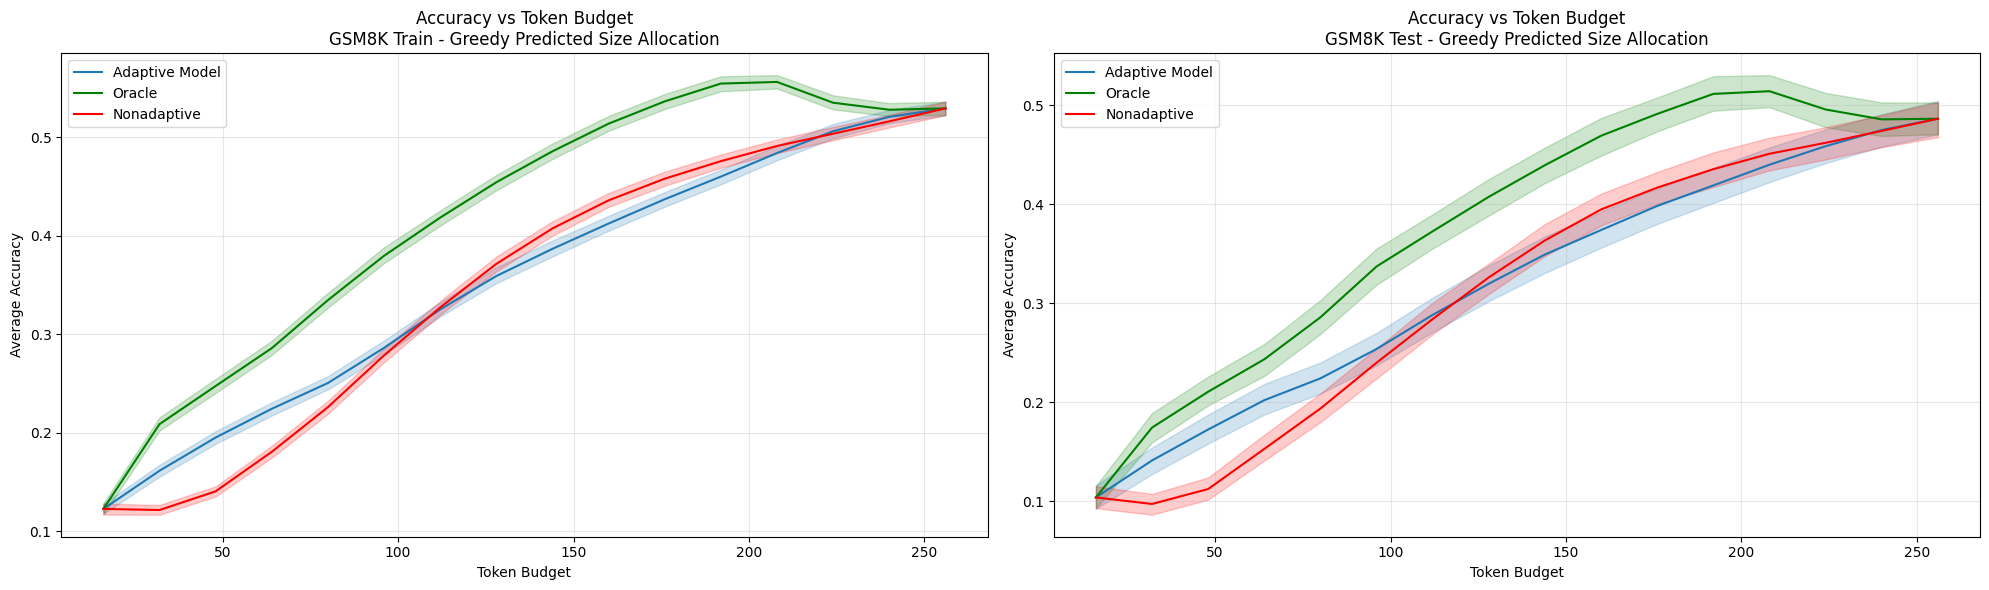

In [76]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Train plot
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_adaptive_model", label='Adaptive Model', ax=ax1)
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_oracle", label='Oracle', color='green', ax=ax1)
sns.lineplot(data=df_res.loc[df_res['split'] == 'train'], x="budget", y="accuracy_nonadaptive", label='Nonadaptive', color='red', ax=ax1)
ax1.set_title('Accuracy vs Token Budget\nGSM8K Train - Greedy Predicted Size Allocation')
ax1.set_xlabel('Token Budget')
ax1.set_ylabel('Average Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test plot
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_adaptive_model", label='Adaptive Model', ax=ax2)
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_oracle", label='Oracle', color='green', ax=ax2)
sns.lineplot(data=df_res.loc[df_res['split'] == 'test'], x="budget", y="accuracy_nonadaptive", label='Nonadaptive', color='red', ax=ax2)
ax2.set_title('Accuracy vs Token Budget\nGSM8K Test - Greedy Predicted Size Allocation')
ax2.set_xlabel('Token Budget')
ax2.set_ylabel('Average Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [77]:
df_res.to_csv("data/plot_size.csv")

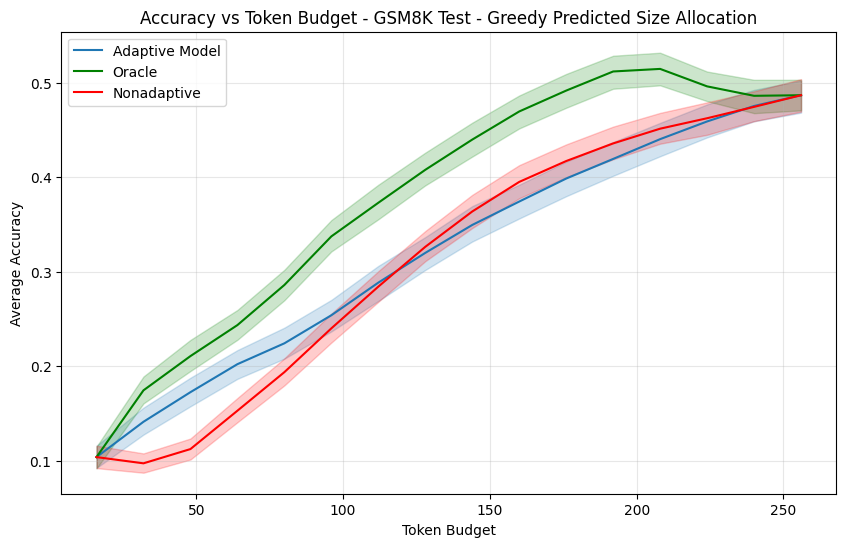

# Overlay size and difficulty predictions

In [100]:
df_difficulty = pd.read_csv("data/plot_difficulty.csv")
df_size = pd.read_csv("data/plot_size.csv")

# Merge the two dataframes on question_id
df_merged = pd.merge(df_difficulty[["question_id", "accuracy_difficulty_pred_model", "budget"]], df_size, on=['question_id','budget'], how='left')

# Create a figure with two subplots side by side
print(df_merged.shape, df_difficulty.shape, df_size.shape)
print(df_merged.columns)


(139904, 9) (139904, 15) (139904, 8)
Index(['question_id', 'accuracy_difficulty_pred_model', 'budget', 'Unnamed: 0',
       'allocation', 'accuracy_adaptive_model', 'accuracy_nonadaptive',
       'accuracy_oracle', 'split'],
      dtype='object')


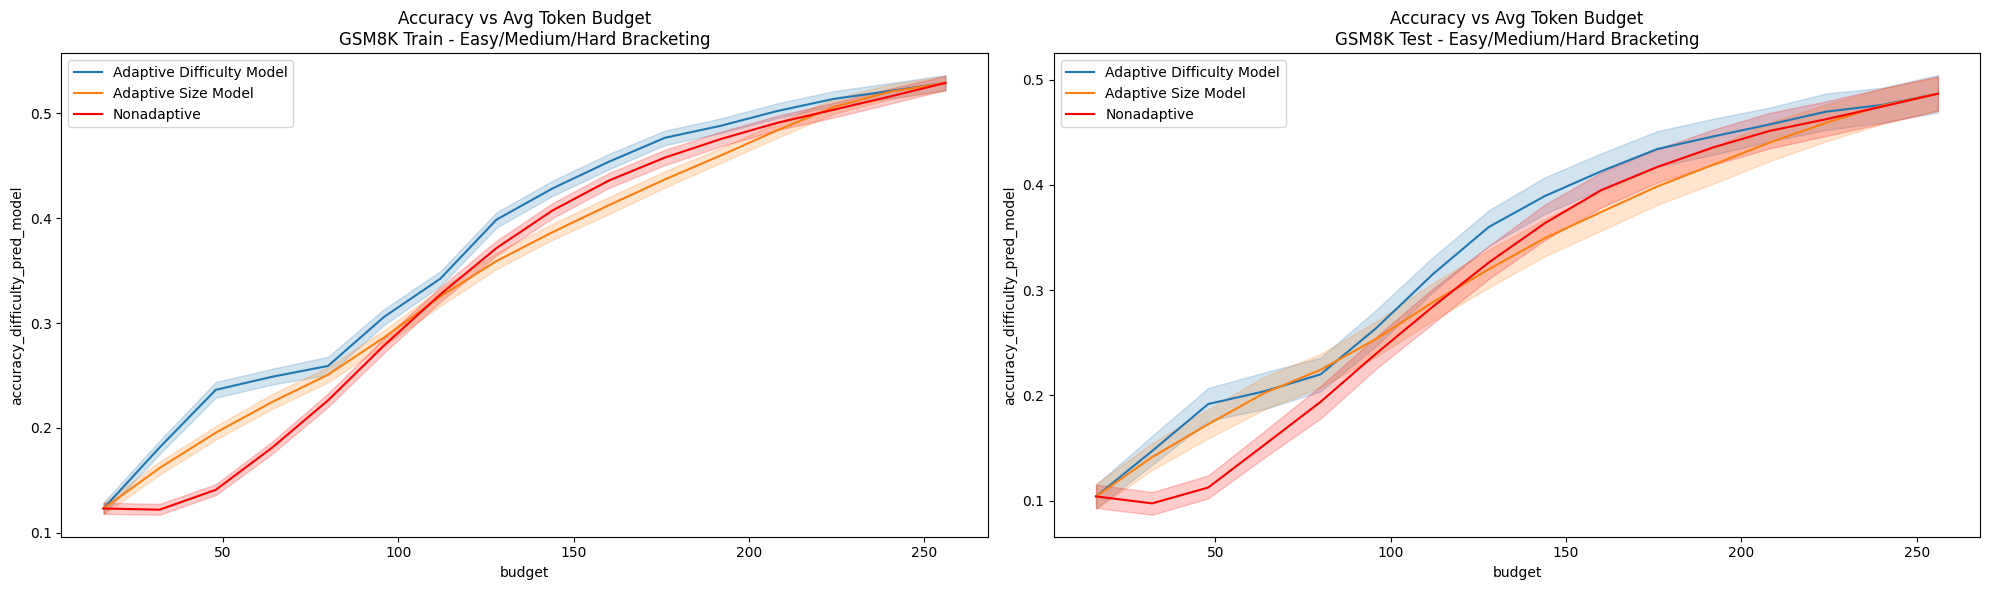

In [102]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Train plot
#sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_zeroshot", label='Adaptive Zeroshot', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Difficulty Model', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_adaptive_model", label='Adaptive Size Model', ax=ax1)
sns.lineplot(data=df_merged.query("split == 'train'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax1, color='red')
ax1.set_title('Accuracy vs Avg Token Budget\nGSM8K Train - Easy/Medium/Hard Bracketing')
ax1.legend()

# Test plot
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_difficulty_pred_model", label='Adaptive Difficulty Model', ax=ax2)
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_adaptive_model", label='Adaptive Size Model', ax=ax2)
sns.lineplot(data=df_merged.query("split == 'test'"), x="budget", y="accuracy_nonadaptive", label='Nonadaptive', ax=ax2, color='red')
ax2.set_title('Accuracy vs Avg Token Budget\nGSM8K Test - Easy/Medium/Hard Bracketing')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [86]:
df_difficulty.head()

,Unnamed: 0,question_id,budget,proportion,difficulty,difficulty_pred_zeroshot,difficulty_pred_model,split,accuracy_nonadaptive,budget_difficulty_pred_zeroshot,accuracy_difficulty_pred_zeroshot,budget_difficulty_pred_model,accuracy_difficulty_pred_model,budget_difficulty,accuracy_difficulty
0,0,test_0,16,"[0.04, 0.12000000000000002, 0.04, 0.0300000000...",medium,medium,medium,test,0.04,16,0.04,16,0.04,16,0.04
1,1,test_1,16,"[0.63, 0.63, 0.83, 0.88, 0.86, 0.94, 0.94, 0.9...",easy,easy,medium,test,0.63,16,0.63,16,0.63,16,0.63
2,2,test_2,16,"[0.02, 0.0, 0.02, 0.01, 0.0, 0.01, 0.01, 0.02,...",hard,medium,medium,test,0.02,16,0.02,16,0.02,16,0.02
3,3,test_3,16,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",hard,hard,medium,test,0.01,16,0.01,16,0.01,16,0.01
4,4,test_4,16,"[0.4, 0.25, 0.09, 0.03, 0.05, 0.36, 0.55, 0.69...",medium,medium,medium,test,0.40,16,0.40,16,0.40,16,0.40


In [80]:
df_size.head()

,Unnamed: 0,question_id,budget,allocation,accuracy_adaptive_model,accuracy_nonadaptive,accuracy_oracle,split
0,0,train_0,16,16,0.00,0.00,0.00,train
1,1,train_1,16,16,0.65,0.65,0.65,train
2,2,train_2,16,16,0.00,0.00,0.00,train
3,3,train_3,16,16,0.01,0.01,0.01,train
4,4,train_4,16,16,0.00,0.00,0.00,train


In [85]:
sorted(df_difficulty["question_id"].unique()) == sorted(df_size["question_id"].unique())


True